In [1]:
from sklearn.datasets import fetch_olivetti_faces

# Autoencoders

 Autoencoders are neural networks designed to learn efficient, lower-dimensional representations of input data in an unsupervised way. They consist of two main parts: an encoder that maps an input $\mathbf{x}$ to a latent code $\mathbf{z}$, and a decoder that reconstructs the input from this code. Formally, the encoder implements a function $f_\theta: \mathbf{x} \mapsto \mathbf{z}$ and the decoder a function $g_\phi: \mathbf{z} \mapsto \hat{\mathbf{x}}$, where $\hat{\mathbf{x}}$ is the reconstruction of the input. Autoencoders are trained to minimize the reconstruction loss between input and output, commonly using the mean squared error: 

$$
\mathcal{L}(\mathbf{x}, \hat{\mathbf{x}}) = \|\mathbf{x} - \hat{\mathbf{x}}\|^2_2
$$

By learning to compress and decompress the data through their bottleneck (latent space), autoencoders can perform dimensionality reduction, denoising, or extract useful features for downstream tasks.



In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [4]:
faces = fetch_olivetti_faces(shuffle=True, download_if_missing=True)
data = faces.images  # shape (400, 64, 64), float32, already between 0 and 1
# Convert to torch tensors and add channel dimension
data_tensor = torch.tensor(data).unsqueeze(1)  # (400, 1, 64, 64)
dataset = torch.utils.data.TensorDataset(data_tensor)
loader = torch.utils.data.DataLoader(
    dataset=dataset, batch_size=32, shuffle=True)

In [29]:
# Redefinir y reutilizar el modelo AE para imágenes de 64x64 (4096 píxeles)

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64 * 64),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [30]:

# Crear nuevo modelo y volver a poner en dispositivo
model = AE()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

Epoch 1/20, Loss: 0.016713
Epoch 2/20, Loss: 0.021017
Epoch 3/20, Loss: 0.017739
Epoch 4/20, Loss: 0.020304
Epoch 5/20, Loss: 0.021045
Epoch 6/20, Loss: 0.018544
Epoch 7/20, Loss: 0.018455
Epoch 8/20, Loss: 0.015253
Epoch 9/20, Loss: 0.018309
Epoch 10/20, Loss: 0.015583
Epoch 11/20, Loss: 0.016563
Epoch 12/20, Loss: 0.015018
Epoch 13/20, Loss: 0.014854
Epoch 14/20, Loss: 0.015721
Epoch 15/20, Loss: 0.015059
Epoch 16/20, Loss: 0.014015
Epoch 17/20, Loss: 0.015136
Epoch 18/20, Loss: 0.017347
Epoch 19/20, Loss: 0.014641
Epoch 20/20, Loss: 0.014809


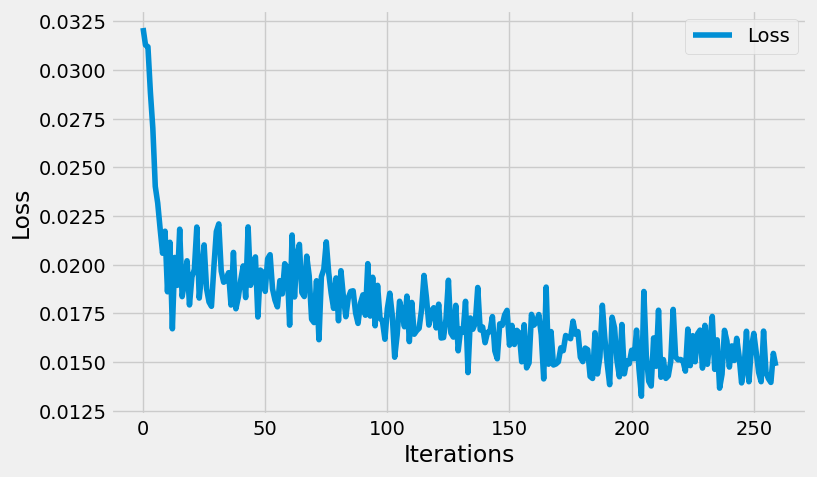

In [31]:



epochs = 20
outputs = []
losses = []

for epoch in range(epochs):
    for batch in loader:
        # Cuando el dataset solo tiene un tensor, cada batch es un tuple de longitud 1
        images = batch[0]
        # Cambiar a (batch_size, 64*64) ya que las imágenes son de 64x64
        images = images.view(images.size(0), -1).to(device)
        
        reconstructed = model(images)
        loss = loss_function(reconstructed, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

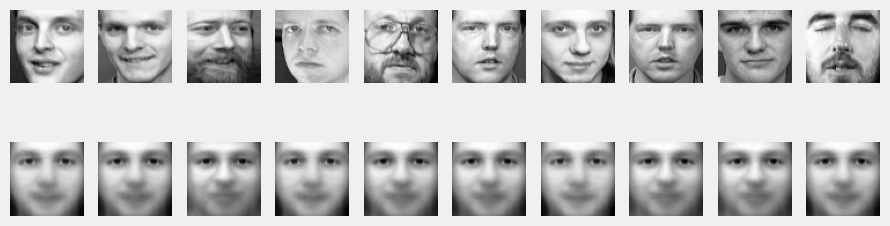

In [32]:
model.eval()
dataiter = iter(loader)
batch = next(dataiter)
# Cuando el dataset solo tiene un tensor, cada batch es un tuple de longitud 1
images = batch[0]

images = images.view(images.size(0), -1).to(device)
reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(64, 64), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(64, 64), cmap='gray')
    axes[1, i].axis('off')
plt.show()

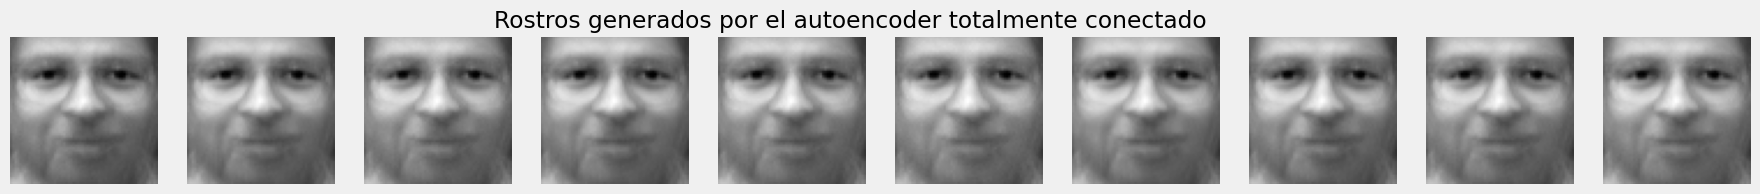

In [36]:
# Generar una serie de rostros sintéticos a partir del autoencoder entrenado usando el modelo totalmente conectado AE
# Basado en el autoencoder definido en las líneas 1-32 de este notebook.

model.eval()
num_faces = 10
latent_dim = 4  # Según la última capa del encoder en la clase AE

# Muestrea puntos aleatorios en el espacio latente del AE (vectorial, no feature map)
random_latents = torch.randn(num_faces, latent_dim).to(device)

# Genera imágenes sintéticas usando el decodificador del AE
with torch.no_grad():
    generated = model.decoder(random_latents)  # (num_faces, 4096)
    generated_images = generated.cpu().numpy().reshape(num_faces, 64, 64)

# Visualiza los rostros generados
fig, axes = plt.subplots(1, num_faces, figsize=(num_faces*2, 2))
for i in range(num_faces):
    axes[i].imshow(generated_images[i], cmap='gray')
    axes[i].axis('off')
plt.suptitle("Rostros generados por el autoencoder totalmente conectado")
plt.show()


Epoch 1/30, Loss: 0.033439
Epoch 2/30, Loss: 0.025534
Epoch 3/30, Loss: 0.018843
Epoch 4/30, Loss: 0.020003
Epoch 5/30, Loss: 0.013651
Epoch 6/30, Loss: 0.009135
Epoch 7/30, Loss: 0.008894
Epoch 8/30, Loss: 0.007524
Epoch 9/30, Loss: 0.006936
Epoch 10/30, Loss: 0.006488
Epoch 11/30, Loss: 0.006384
Epoch 12/30, Loss: 0.006658
Epoch 13/30, Loss: 0.006428
Epoch 14/30, Loss: 0.006374
Epoch 15/30, Loss: 0.006133
Epoch 16/30, Loss: 0.006012
Epoch 17/30, Loss: 0.005243
Epoch 18/30, Loss: 0.006200
Epoch 19/30, Loss: 0.006392
Epoch 20/30, Loss: 0.005140
Epoch 21/30, Loss: 0.005468
Epoch 22/30, Loss: 0.005941
Epoch 23/30, Loss: 0.005509
Epoch 24/30, Loss: 0.005207
Epoch 25/30, Loss: 0.004970
Epoch 26/30, Loss: 0.005018
Epoch 27/30, Loss: 0.004193
Epoch 28/30, Loss: 0.004621
Epoch 29/30, Loss: 0.004278
Epoch 30/30, Loss: 0.004362


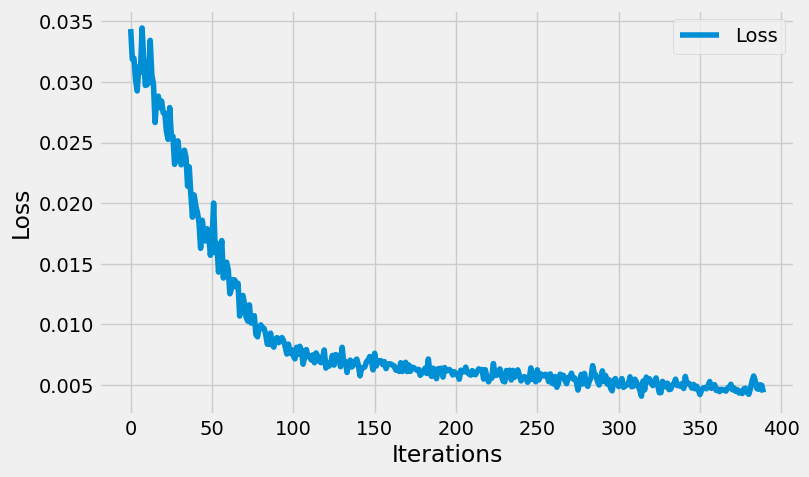

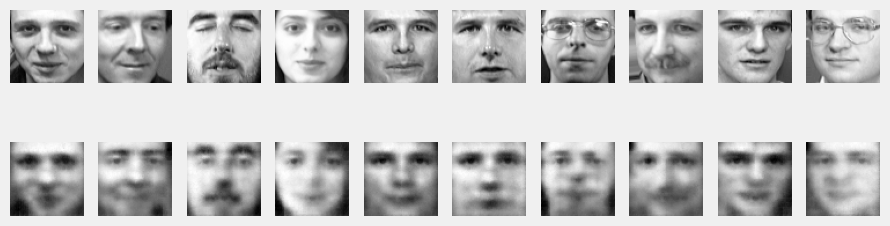

In [19]:
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [B, 16, 32, 32]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [B, 32, 16, 16]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [B, 64, 8, 8]
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),# [B, 128, 4, 4]
            nn.ReLU(True),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # [B, 64, 8, 8]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # [B, 32, 16, 16]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [B, 16, 32, 32]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # [B, 1, 64, 64]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 1, 64, 64)  # Asegura que las imágenes tienen canal único y son 64x64
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 64*64)      # Reconstruimos la forma plana si la necesitas para comparación
        return x

# Reemplaza la definición/instancia de tu modelo por este:
model = ConvAutoencoder().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Debes ajustar el entrenamiento y evaluación para trabajar con imágenes en formato (B,1,64,64).
# Entrenamiento:
losses = []
outputs = []
epochs = 30  # Ajusta según necesidad

for epoch in range(epochs):
    for batch in loader:
        images = batch[0].to(device)
        # Si imágenes está en formato [B, 1, 64, 64], no necesitas hacer reshape.
        reconstructed = model(images)
        # La salida del modelo se aplana, así que aplanamos las imágenes también
        loss = loss_function(reconstructed, images.view(images.size(0), -1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

# Visualización de pérdidas
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualización de imágenes originales y reconstruidas
model.eval()
dataiter = iter(loader)
batch = next(dataiter)
images = batch[0].to(device)
with torch.no_grad():
    reconstructed = model(images)
reconstructed = reconstructed.view(-1, 1, 64, 64)
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i,0].cpu().detach().numpy(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i,0].cpu().detach().numpy(), cmap='gray')
    axes[1, i].axis('off')
plt.show()



# Variational Autoencoders (VAEs)

Variational Autoencoders (VAEs) are a class of generative models that combine ideas from deep learning with probabilistic graphical models. Unlike standard autoencoders, which learn a deterministic mapping to a latent space, VAEs learn a probabilistic mapping, enabling both efficient dimension reduction and generative capabilities.
The key idea behind a VAE is to learn an approximate posterior distribution $q_\phi(z|x)$ over the latent variables $z$, given the observed data $x$. The generative process assumes that the data is generated from some prior $p(z)$, typically a standard normal distribution, and a likelihood model $p_\theta(x|z)$ parameterized by a neural network (the decoder).
Since directly maximizing the log-likelihood $\log p(x)$ is intractable due to the integration over latent variable $z$, VAEs optimize the Evidence Lower Bound (ELBO):
$$
\log p(x) \geq \mathbb{E}_{q_\phi(z|x)} [\log p_\theta(x|z)] - \mathrm{KL}(q_\phi(z|x) \| p(z))
$$
The first term, $\mathbb{E}_{q_\phi(z|x)} [\log p_\theta(x|z)]$, is the expected reconstruction log-likelihood (e.g., binary cross-entropy loss), while the second term, $\mathrm{KL}(q_\phi(z|x) \| p(z))$, is the Kullback-Leibler divergence that regularizes the learned latent distribution $q_\phi(z|x)$ to be close to the prior $p(z)$.
VAEs use the "reparameterization trick" to make backpropagation through the sampling operation feasible:
$$
z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$
Here, $\mu_\phi(x)$ and $\sigma_\phi(x)$ are the mean and standard deviation outputs of the encoder network for input $x$, and $\epsilon$ is random Gaussian noise.
VAEs provide a principled framework for deep generative modeling, combining the expressiveness of neural networks with robust probabilistic inference.

VAE Epoch 1/40, Loss: 2793.952236
VAE Epoch 2/40, Loss: 2750.732568
VAE Epoch 3/40, Loss: 2742.435107
VAE Epoch 4/40, Loss: 2736.294766
VAE Epoch 5/40, Loss: 2733.978457
VAE Epoch 6/40, Loss: 2725.583545
VAE Epoch 7/40, Loss: 2711.143945
VAE Epoch 8/40, Loss: 2704.018633
VAE Epoch 9/40, Loss: 2700.092344
VAE Epoch 10/40, Loss: 2697.085645
VAE Epoch 11/40, Loss: 2691.306504
VAE Epoch 12/40, Loss: 2687.862051
VAE Epoch 13/40, Loss: 2687.853457
VAE Epoch 14/40, Loss: 2684.462314
VAE Epoch 15/40, Loss: 2683.469150
VAE Epoch 16/40, Loss: 2683.252432
VAE Epoch 17/40, Loss: 2682.304414
VAE Epoch 18/40, Loss: 2685.114424
VAE Epoch 19/40, Loss: 2679.694893
VAE Epoch 20/40, Loss: 2679.118350
VAE Epoch 21/40, Loss: 2677.882812
VAE Epoch 22/40, Loss: 2678.364395
VAE Epoch 23/40, Loss: 2680.063906
VAE Epoch 24/40, Loss: 2675.369180
VAE Epoch 25/40, Loss: 2671.887383
VAE Epoch 26/40, Loss: 2671.023584
VAE Epoch 27/40, Loss: 2671.459863
VAE Epoch 28/40, Loss: 2669.956816
VAE Epoch 29/40, Loss: 2669.0

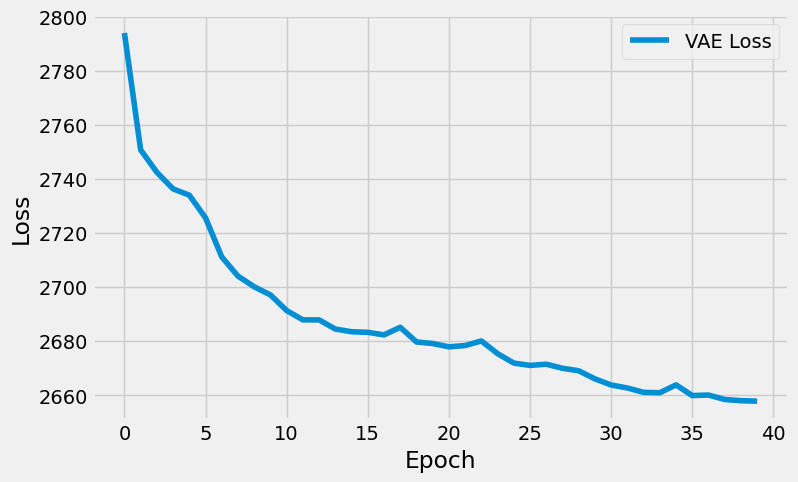

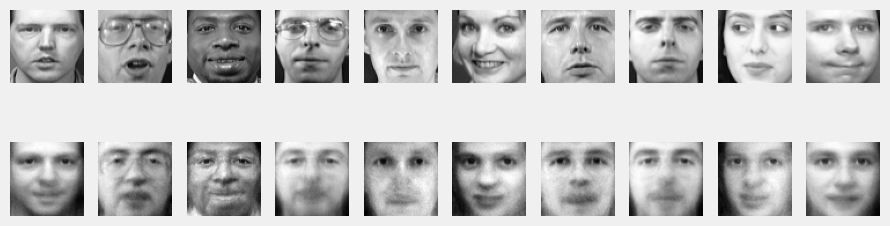

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Definimos la estructura del VAE

class VAE(nn.Module):
    def __init__(self, input_dim=64*64, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # logvar

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(x.size(0), -1))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function del VAE
def vae_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(x.size(0), -1), reduction='sum')
    # Kullback-Leibler divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Inicializamos el VAE y el optimizador
vae = VAE().to(device)
vae_optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Entrenamiento del VAE
vae_epochs = 40
vae_losses = []

for epoch in range(vae_epochs):
    vae.train()
    train_loss = 0
    for batch in loader:
        images = batch[0].to(device)
        vae_optimizer.zero_grad()
        recon_batch, mu, logvar = vae(images)
        loss = vae_loss_function(recon_batch, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        vae_optimizer.step()
    avg_loss = train_loss / len(loader.dataset)
    vae_losses.append(avg_loss)
    print(f"VAE Epoch {epoch+1}/{vae_epochs}, Loss: {avg_loss:.6f}")

# Visualización de la curva de pérdida del VAE
plt.figure(figsize=(8, 5))
plt.plot(vae_losses, label='VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualización de imágenes originales y reconstruidas por el VAE
vae.eval()
dataiter = iter(loader)
batch = next(dataiter)
images = batch[0].to(device)
with torch.no_grad():
    recon_batch, _, _ = vae(images)
recon_images = recon_batch.view(-1, 1, 64, 64)
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i,0].cpu().detach().numpy(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon_images[i,0].cpu().detach().numpy(), cmap='gray')
    axes[1, i].axis('off')
plt.show()



ConvVAE Epoch 1/200, Loss: 2936.225117
ConvVAE Epoch 2/200, Loss: 2738.743545
ConvVAE Epoch 3/200, Loss: 2702.028359
ConvVAE Epoch 4/200, Loss: 2690.219336
ConvVAE Epoch 5/200, Loss: 2681.794980
ConvVAE Epoch 6/200, Loss: 2673.459912
ConvVAE Epoch 7/200, Loss: 2668.101992
ConvVAE Epoch 8/200, Loss: 2665.189746
ConvVAE Epoch 9/200, Loss: 2661.277187
ConvVAE Epoch 10/200, Loss: 2656.297773
ConvVAE Epoch 11/200, Loss: 2654.127725
ConvVAE Epoch 12/200, Loss: 2650.802627
ConvVAE Epoch 13/200, Loss: 2648.945244
ConvVAE Epoch 14/200, Loss: 2646.084150
ConvVAE Epoch 15/200, Loss: 2644.312412
ConvVAE Epoch 16/200, Loss: 2644.416270
ConvVAE Epoch 17/200, Loss: 2643.059814
ConvVAE Epoch 18/200, Loss: 2641.889941
ConvVAE Epoch 19/200, Loss: 2639.791660
ConvVAE Epoch 20/200, Loss: 2638.747861
ConvVAE Epoch 21/200, Loss: 2637.901689
ConvVAE Epoch 22/200, Loss: 2636.905273
ConvVAE Epoch 23/200, Loss: 2635.121230
ConvVAE Epoch 24/200, Loss: 2633.683340
ConvVAE Epoch 25/200, Loss: 2632.339434
ConvVAE E

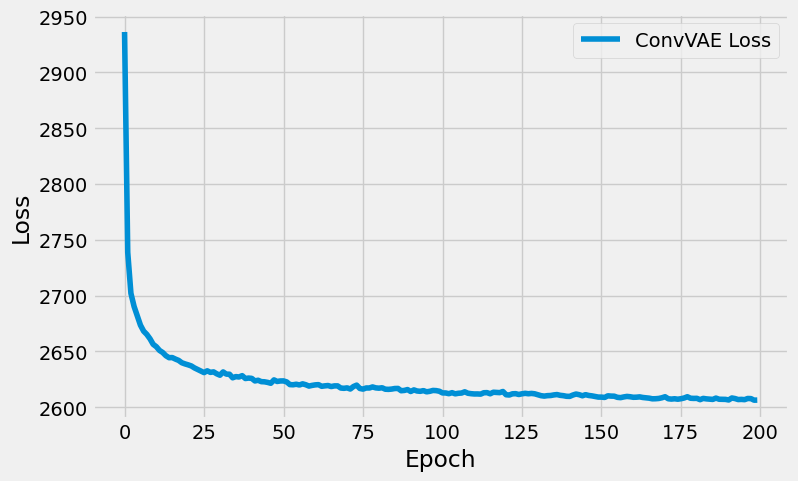

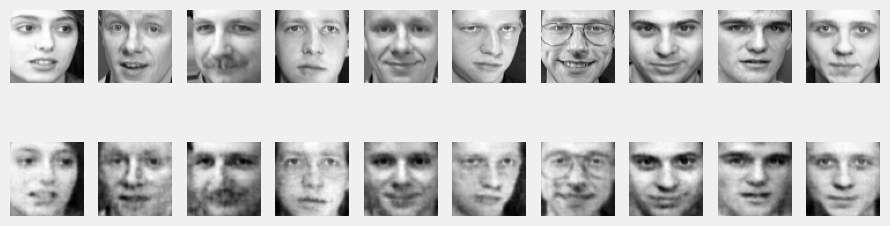

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(ConvVAE, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # 64x64 -> 32x32
        self.enc_bn1 = nn.BatchNorm2d(32)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # 32x32 -> 16x16
        self.enc_bn2 = nn.BatchNorm2d(64)
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # 16x16 -> 8x8
        self.enc_bn3 = nn.BatchNorm2d(128)
        self.enc_conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # 8x8 -> 4x4
        self.enc_bn4 = nn.BatchNorm2d(256)

        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 256*4*4)
        self.dec_convT1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # 4x4 -> 8x8
        self.dec_bn1 = nn.BatchNorm2d(128)
        self.dec_convT2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # 8x8 -> 16x16
        self.dec_bn2 = nn.BatchNorm2d(64)
        self.dec_convT3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # 16x16 -> 32x32
        self.dec_bn3 = nn.BatchNorm2d(32)
        self.dec_convT4 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)  # 32x32 -> 64x64

    def encode(self, x):
        h = F.relu(self.enc_bn1(self.enc_conv1(x)))
        h = F.relu(self.enc_bn2(self.enc_conv2(h)))
        h = F.relu(self.enc_bn3(self.enc_conv3(h)))
        h = F.relu(self.enc_bn4(self.enc_conv4(h)))
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 256, 4, 4)
        h = F.relu(self.dec_bn1(self.dec_convT1(h)))
        h = F.relu(self.dec_bn2(self.dec_convT2(h)))
        h = F.relu(self.dec_bn3(self.dec_convT3(h)))
        h = torch.sigmoid(self.dec_convT4(h))
        return h

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

def conv_vae_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Instancia y entrenamiento del VAE convolucional
conv_vae = ConvVAE(latent_dim=16).to(device)
conv_vae_optimizer = torch.optim.Adam(conv_vae.parameters(), lr=1e-3)
conv_vae_epochs = 200
conv_vae_losses = []

for epoch in range(conv_vae_epochs):
    conv_vae.train()
    train_loss = 0
    for batch in loader:
        images = batch[0].to(device)
        conv_vae_optimizer.zero_grad()
        recon_batch, mu, logvar = conv_vae(images)
        loss = conv_vae_loss_function(recon_batch, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        conv_vae_optimizer.step()
    avg_loss = train_loss / len(loader.dataset)
    conv_vae_losses.append(avg_loss)
    print(f"ConvVAE Epoch {epoch+1}/{conv_vae_epochs}, Loss: {avg_loss:.6f}")

# Visualización de la curva de pérdida del VAE convolucional
plt.figure(figsize=(8, 5))
plt.plot(conv_vae_losses, label='ConvVAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualización de algunas imágenes originales y reconstruidas por el VAE convolucional
conv_vae.eval()
dataiter = iter(loader)
batch = next(dataiter)
images = batch[0].to(device)
with torch.no_grad():
    recon_batch, _, _ = conv_vae(images)
recon_images = recon_batch.view(-1, 1, 64, 64)
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i, 0].cpu().detach().numpy(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon_images[i, 0].cpu().detach().numpy(), cmap='gray')
    axes[1, i].axis('off')
plt.show()


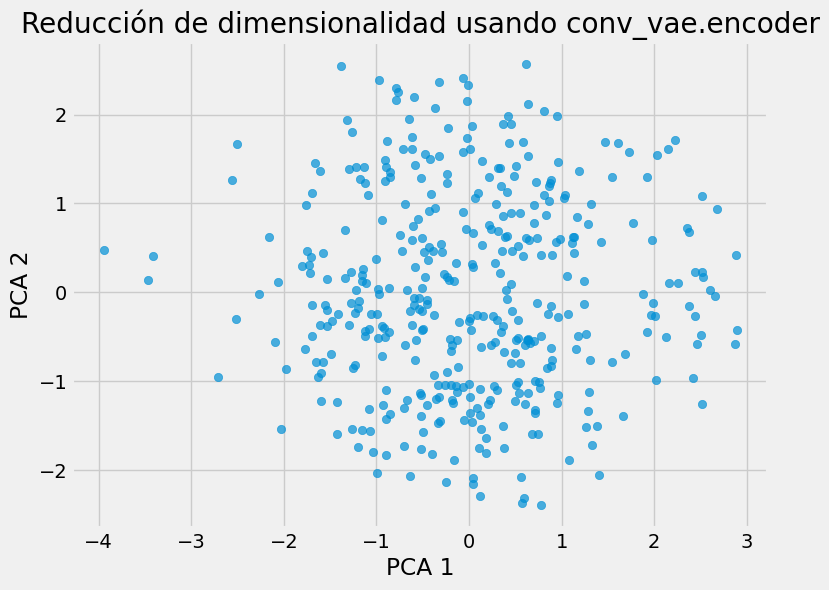

In [25]:
# Usar el encoder del VAE convolucional para reducción de dimensionalidad
conv_vae.eval()
all_latents = []
all_labels = []

with torch.no_grad():
    for batch in loader:
        images = batch[0].to(device)
        mu, logvar = conv_vae.encode(images)
        z = mu  # Utilizamos la media como representación reducida
        all_latents.append(z.cpu())
        if len(batch) > 1:
            all_labels.append(batch[1].cpu())

# Concatenar todos los vectores latentes
import torch
latents = torch.cat(all_latents, dim=0).numpy()
if all_labels:
    labels = torch.cat(all_labels, dim=0).numpy()
else:
    labels = None

# Visualización en 2D usando PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
latents_2d = pca.fit_transform(latents)

plt.figure(figsize=(8,6))
if labels is not None:
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Clase")
else:
    plt.scatter(latents_2d[:, 0], latents_2d[:, 1], alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Reducción de dimensionalidad usando conv_vae.encoder")
plt.show()


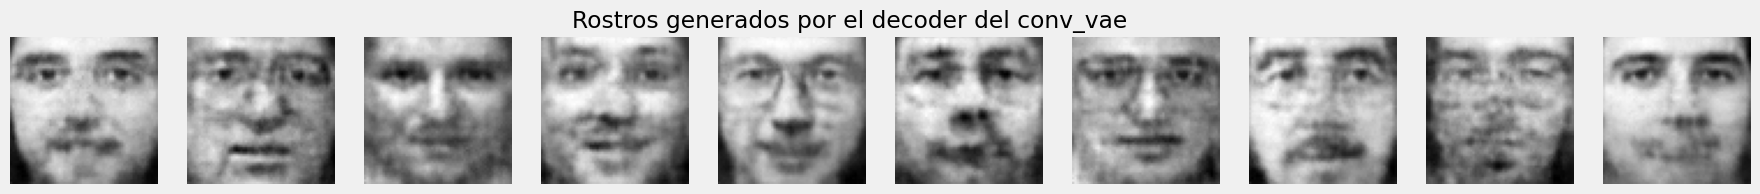

In [28]:
# Ahora usamos el decoder para generar nuevos rostros

import numpy as np

conv_vae.eval()
num_samples = 10

# Usamos la dimensión latente a partir de los latentes existentes
latent_dim = latents.shape[1]

# Muestreamos puntos aleatorios del espacio latente estándar normal
z_samples = torch.randn(num_samples, latent_dim).to(device)

with torch.no_grad():
    generated_images = conv_vae.decode(z_samples)
    generated_images = generated_images.cpu()

# Visualizamos los rostros generados
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
for i in range(num_samples):
    ax = axes[i]
    img = generated_images[i].squeeze().numpy()
    # Si la imagen es [C, H, W], convertir a HWC para mostrar, o a escala de grises si C=1
    if img.ndim == 3 and img.shape[0] in [1,3]:
        # C, H, W a H, W, C
        img = np.transpose(img, (1,2,0))
        if img.shape[2] == 1:
            img = img[:,:,0]
    ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
    ax.axis('off')
plt.suptitle("Rostros generados por el decoder del conv_vae")
plt.show()


# Text autoencoder? 

In [39]:
# Usar la ruta fija proporcionada para cervantes_2.txt
data_path = "/home/robert/Documents/Trabajo/Semillero investigación/Deep-generative-modeling/Data/cervantes_2.txt"
with open(data_path, encoding="utf-8") as f:
    raw_text = f.read()

# Opcional: normalizamos los saltos de línea y eliminamos dobles espacios
raw_text = raw_text.replace('\r\n', '\n').replace('\r', '\n')
raw_text = ' '.join(raw_text.split())

# Haz una lista de oraciones simples (puedes usar split('.') para hacer oraciones simples)
texts = [sent.strip() for sent in raw_text.split('.') if len(sent.strip()) > 0]

# Construye el vocabulario inicial especial con los tokens necesarios
vocab = {'<pad>':0, '<unk>':1}
for text in texts:
    for word in text.split():
        if word not in vocab:
            vocab[word] = len(vocab)


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 1. Tokenización y vectorización básica
vocab = {'<pad>':0, '<unk>':1}
for text in texts:
    for word in text.split():
        if word not in vocab:
            vocab[word] = len(vocab)
inv_vocab = {v: k for k, v in vocab.items()}

def encode(text, vocab, max_len):
    tokens = [vocab.get(w, vocab['<unk>']) for w in text.split()]
    tokens = tokens[:max_len]
    tokens += [vocab['<pad>']] * (max_len - len(tokens))
    return tokens

max_len = max(len(t.split()) for t in texts)
encoded_texts = [encode(t, vocab, max_len) for t in texts]
input_tensor = torch.tensor(encoded_texts)

# 2. Definición de un VAE para texto CONVNET

class ConvTextVAE(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_channels, latent_dim, max_len,kernel_size=3,padding=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # Encoder: Conv1d sobre las secuencias
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(num_channels, num_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),  # Reduce a un vector por batch
        )
        self.fc_mu = nn.Linear(num_channels, latent_dim)
        self.fc_logvar = nn.Linear(num_channels, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, num_channels * max_len)
        
        # Decoder: Conv1d Transpuesta
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(num_channels, num_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(num_channels, embed_dim, kernel_size=3, padding=1),
        )
        self.output = nn.Linear(embed_dim, vocab_size)
        self.max_len = max_len
        self.num_channels = num_channels
        self.embed_dim = embed_dim

    def encode(self, x):
        emb = self.embedding(x)                # (batch, seq, embed_dim)
        emb = emb.transpose(1, 2)              # (batch, embed_dim, seq)
        enc_out = self.encoder(emb)            # (batch, num_channels, 1)
        enc_out = enc_out.squeeze(-1)          # (batch, num_channels)
        mu = self.fc_mu(enc_out)
        logvar = self.fc_logvar(enc_out)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        batch = z.size(0)
        dec_input = self.decoder_input(z)      # (batch, num_channels * max_len)
        dec_input = dec_input.view(batch, self.num_channels, self.max_len)
        dec_out = self.decoder(dec_input)      # (batch, embed_dim, max_len)
        dec_out = dec_out.transpose(1, 2)      # (batch, max_len, embed_dim)
        logits = self.output(dec_out)          # (batch, max_len, vocab_size)
        return logits

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        logits = self.decode(z)
        return logits, mu, logvar

# 3. Entrenamiento simple

vocab_size = len(vocab)
embed_dim = 64
num_channels = 128
latent_dim = 16
kernel_size = 5

model = ConvTextVAE(vocab_size, embed_dim, num_channels, latent_dim, max_len,kernel_size=kernel_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
input_tensor = input_tensor.to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def vae_loss_fn(recon_logits, target, mu, logvar):
    # recon_logits: (batch, max_len, vocab_size)
    CE = loss_fn(recon_logits.view(-1, vocab_size), target.view(-1))
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    KL = KL.mean()
    return CE + KL * 0.01  # Peso pequeño para el KL si reconstrucción es difícil

n_epochs = 300
for epoch in range(n_epochs):
    model.train()
    logits, mu, logvar = model(input_tensor)
    loss = vae_loss_fn(logits, input_tensor, mu, logvar)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{n_epochs} Loss: {loss.item():.4f}")

# 4. Ejemplo de reconstrucción de texto

model.eval()
with torch.no_grad():
    mu, logvar = model.encode(input_tensor)
    z = model.reparameterize(mu, logvar)
    logits = model.decode(z)
    pred_idxs = logits.argmax(-1).cpu().numpy()

print("Reconstrucciones (ConvNet VAE):")
for orig, rec in zip(encoded_texts, pred_idxs):
    orig_text = " ".join([inv_vocab[idx] for idx in orig if idx != vocab['<pad>']])
    rec_text = " ".join([inv_vocab.get(idx, '<unk>') for idx in rec if idx != vocab['<pad>']])
    print(f"Original:     {orig_text}")
    print(f"Reconstruido: {rec_text}")
    print("---")


Epoch 1/300 Loss: 7.9968
Epoch 5/300 Loss: 7.8436
Epoch 10/300 Loss: 7.4098
Epoch 15/300 Loss: 6.9284
Epoch 20/300 Loss: 6.6314
Epoch 25/300 Loss: 6.4754
Epoch 30/300 Loss: 6.4313
Epoch 35/300 Loss: 6.4069
Epoch 40/300 Loss: 6.3828
Epoch 45/300 Loss: 6.3552
Epoch 50/300 Loss: 6.3540
Epoch 55/300 Loss: 6.3286
Epoch 60/300 Loss: 6.3156
Epoch 65/300 Loss: 6.2791
Epoch 70/300 Loss: 6.2469
Epoch 75/300 Loss: 6.1790
Epoch 80/300 Loss: 6.0821
Epoch 85/300 Loss: 5.9736
Epoch 90/300 Loss: 5.8024
Epoch 95/300 Loss: 5.5748
Epoch 100/300 Loss: 5.3161
Epoch 105/300 Loss: 5.0269
Epoch 110/300 Loss: 4.7816
Epoch 115/300 Loss: 4.5631
Epoch 120/300 Loss: 4.3955
Epoch 125/300 Loss: 4.2298
Epoch 130/300 Loss: 4.0906
Epoch 135/300 Loss: 3.9246
Epoch 140/300 Loss: 3.7693
Epoch 145/300 Loss: 3.6043
Epoch 150/300 Loss: 3.4247
Epoch 155/300 Loss: 3.2280
Epoch 160/300 Loss: 2.9999
Epoch 165/300 Loss: 2.7698
Epoch 170/300 Loss: 2.5149
Epoch 175/300 Loss: 2.2778
Epoch 180/300 Loss: 2.0489
Epoch 185/300 Loss: 1.8

In [49]:
# Usar la ConvNet VAE entrenada para generar texto aleatorio desde el espacio latente

model.eval()
with torch.no_grad():
    # Muestreamos un vector latente z de una normal estándar
    z = torch.randn(1, latent_dim).to(device)
    # Decodificamos a logits
    logits = model.decode(z)
    # Obtenemos los índices predichos (palabras)
    pred_idxs = logits.argmax(-1).cpu().numpy()[0]

    # Convertimos los índices en palabras, ignorando <pad>
    generated_text = " ".join([inv_vocab.get(idx, '<unk>') for idx in pred_idxs if idx != vocab['<pad>']])
    print("Texto generado (ConvNet VAE):")
    print(generated_text)


Texto generado (ConvNet VAE):
Y la bajó de que por le responder que en más -respondió de y como de don Quijote y se jurado nada-, la en y fuera y su de y muchos en de lo la que él ponía no razón de que había invenciones y leía, natural aun de la puesto le della hecho cierta que armas, a y lo que la un diablo lo oír tanta si cuales, la empleada las de que su esfuerzo las ganase y del lanza y y de en el de de menesterosos, como caballero, Quijote vuestra de con su y por su huida tuviera como mi la cuyo de a y fazañas su inclinado para polvoroso voces: a de y se y al cuando de de la los de mercedes, sin de desaguisado alguno, en rompió sobre orden y ahora que de non toca y como diversas razón alguna cuanto de y tan que cuanto pies, corral presencias demuestran manos, pareció de la recuestando salió viudas, y, cual entre y es a allí pupilos y, esto, dándose a conocer le cuantas audiencias y verdad hay ello de toda España; y se a pasados que se de venido a recoger a solo su es donde respond

In [50]:
# Contar el número de parámetros del modelo
total_params = sum(p.numel() for p in model.parameters())
print(f"Número total de parámetros en el modelo: {total_params}")


Número total de parámetros en el modelo: 1245200
